# Experiment with complete Lagrangian from exponentiated gradient as grid for grid search

In this, we compare time, violation and error from expgrad on full dataset, gridsearch on full dataset, hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).

3. Normalised values are calculated by: `({value}-{eps}) / {eps}` for violation and `({value}-{exp full dataset})/{exp full dataset}` for error.


In [1]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train_all = pd.DataFrame(X)
A_train_all = pd.Series(A)
y_train_all = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
# Subsampling process
#fractions = [0.01,0.05,0.1,0.2,0.5,0.8,0.9,1]
#fractions = [0.01,0.05]
fractions = [0.001, 0.002, 0.005, 0.008, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 0.9]
eps = 0.003
A_trains = []
X_trains = []
y_trains = []

for f in fractions: 
    subsampling = train_all.sample(frac=f)
    subsampling = subsampling.reset_index()
    subsampling = subsampling.drop(columns=['index'])
    tmp = subsampling.iloc[:, :-1]
    A_train = subsampling.iloc[:, -1]
    X_train = tmp.iloc[:, :-1]
    y_train = tmp.iloc[:,-1]
    A_trains.append(A_train)
    X_trains.append(X_train)
    y_trains.append(y_train)

In [8]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

In [10]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

Logistic Regression - Violation: 0.12424042105058944, Error: 0.1586253493443076


In [11]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

a=datetime.now()
expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all = error.gamma(Qexp_all)[0]

print('Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all, error_expgrad_all))

Exponentiated gradient on full dataset : Time: 68 seconds; Violation: 0.0030000000000001137; Errror: 0.1770107780079719


In [12]:
# grid search with 0 as center
grid_X_logistic = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                             constraints=DemographicParity())

a=datetime.now()
grid_X_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
time_grid_all = (b-a).seconds

def Qgrid_all(X): return grid_X_logistic.predict(X)
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_grid_all = disparity_moment.gamma(Qgrid_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
error_grid_all = error.gamma(Qgrid_all)['all']

print('Grid Search on full dataset with 0 offset: Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_grid_all, violation_grid_all, error_grid_all))


Grid Search on full dataset with 0 offset: Time: 29 seconds; Violation: 0.053235051159029406; Errror: 0.16535118700285617


## Experiment 1: Hybrid 1

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the best classifier out of all the predictors.

In [13]:
# hybrid model

# Variables
time_expgrad_fracs = []
time_grid_fracs = []
time_hybrids = []
time_expgrad_alls = []
time_grid_alls = []

error_expgrad_fracs = []
error_grid_fracs = []
error_hybrids = []
error_expgrad_alls = []
error_grid_alls = []

vio_expgrad_fracs = []
vio_grid_fracs = []
vio_hybrids = []
vio_expgrad_alls = []
vio_grid_alls = []

#variables for exp: 2
weights_exp_fracs = []
predictors_grid_fracs = []

# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_all)
    vio_expgrad_alls.append(violation_expgrad_all)
    
    time_grid_alls.append(time_grid_all)
    error_grid_alls.append(error_grid_all)
    vio_grid_alls.append(violation_grid_all)
    
    A_train = A_trains[i]
    X_train = X_trains[i]
    y_train = y_trains[i]
    
    # Expgrad on sub dataset
    expgrad_X_logistic_frac = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True),
        constraints=DemographicParity(), eps=eps, nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_frac = (b-a).seconds
    time_expgrad_fracs.append(time_expgrad_frac)
    
    def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all,
                               sensitive_features=A_train_all)
    violation_expgrad_logistic_frac = disparity_moment.gamma(Qexp).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all,
                    sensitive_features=A_train_all)
    error_expgrad_logistic_frac = error.gamma(Qexp)[0]
    
    error_expgrad_fracs.append(error_expgrad_logistic_frac)
    vio_expgrad_fracs.append(violation_expgrad_logistic_frac)
    
    weights_exp_fracs.append(expgrad_X_logistic_frac._weights)
    
    
    # Grid Search part
    lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
    grid_search_logistic_frac = GridSearch(
        LogisticRegression(solver='liblinear', fit_intercept=True),
        constraints=DemographicParity(), grid=lambda_vecs_logistic)
    a=datetime.now()  
    grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                  sensitive_features=A_train_all)
    b=datetime.now()
    time_grid_frac = (b-a).seconds
    time_grid_fracs.append(time_grid_frac)
    time_hybrids.append(time_grid_frac + time_expgrad_frac)
    
    def Qgrid(X): return grid_search_logistic_frac.predict(X)
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all,
                               sensitive_features=A_train_all)
    violation_grid_frac = disparity_moment.gamma(Qgrid).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all,
                    sensitive_features=A_train_all)
    error_grid_frac = error.gamma(Qgrid)['all']
    
    vio_hybrids.append(violation_grid_frac)
    error_hybrids.append(error_grid_frac)
    
    vio_grid_fracs.append(violation_grid_frac)
    error_grid_fracs.append(error_grid_frac)
    
    predictors_grid_fracs.append(grid_search_logistic_frac._predictors)


Liblinear failed to converge, increase the number of iterations.


Model			Fraction	Time Taken (in secs)	
Exp.Grad. on full	-		68
Grid Search on full	-		29
---------------------------------------------
Exp.Grad. on subset	0.001		0
Exp.Grad. on subset	0.002		0
Exp.Grad. on subset	0.005		1
Exp.Grad. on subset	0.008		1
Exp.Grad. on subset	0.01		1
Exp.Grad. on subset	0.02		2
Exp.Grad. on subset	0.05		4
Exp.Grad. on subset	0.08		7
Exp.Grad. on subset	0.1		6
Exp.Grad. on subset	0.2		10
Exp.Grad. on subset	0.5		26
Exp.Grad. on subset	0.8		49
Exp.Grad. on subset	0.9		48
---------------------------------------------
Hybrid (Total time)	0.001		10
Hybrid (Total time)	0.002		10
Hybrid (Total time)	0.005		29
Hybrid (Total time)	0.008		15
Hybrid (Total time)	0.01		31
Hybrid (Total time)	0.02		29
Hybrid (Total time)	0.05		49
Hybrid (Total time)	0.08		45
Hybrid (Total time)	0.1		25
Hybrid (Total time)	0.2		36
Hybrid (Total time)	0.5		59
Hybrid (Total time)	0.8		91
Hybrid (Total time)	0.9		80


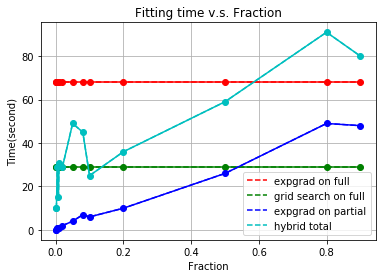

In [14]:
# Print Time and plot them

print('Model\t\t\tFraction\tTime Taken (in secs)\t')
print('{}\t{}\t\t{}'.format('Exp.Grad. on full', '-', time_expgrad_alls[0]))
print('{}\t{}\t\t{}'.format('Grid Search on full', '-', time_grid_alls[0]))
print('---------------------------------------------')
for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format('Exp.Grad. on subset',
                                fractions[i], time_expgrad_fracs[i]))
    
print('---------------------------------------------')
for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format('Hybrid (Total time)',
                                fractions[i], time_hybrids[i]))
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, time_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, time_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, time_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, time_hybrids,'c--',label="hybrid total")
plt.plot(fractions, time_expgrad_alls,'ro-', fractions, time_grid_alls,'go-',
         fractions, time_expgrad_fracs,'bo-', fractions, time_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Time(second)')
plt.title('Fitting time v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Error	Normalised Error
Exp.Grad. on full	-		0.1770107780079719	0.0
Grid Search on full	-		0.16535118700285617	-0.06586938454442945
---------------------------------------------
Exp.Grad. on subset	0.001		0.2596996206178793	0.46714015689023985
Exp.Grad. on subset	0.002		0.2503181172892152	0.4141405405152324
Exp.Grad. on subset	0.005		0.22046979643931552	0.2455162274321306
Exp.Grad. on subset	0.008		0.21189797874634753	0.19709082763765057
Exp.Grad. on subset	0.01		0.20139012902208916	0.13772805977396077
Exp.Grad. on subset	0.02		0.19164476671515632	0.08267286812628634
Exp.Grad. on subset	0.05		0.1789273469198095	0.010827413637780123
Exp.Grad. on subset	0.08		0.17417206180799147	-0.016036968098364014
Exp.Grad. on subset	0.1		0.17689372162078817	-0.000661295252758349
Exp.Grad. on subset	0.2		0.1802196356827461	0.01812803554046678
Exp.Grad. on subset	0.5		0.17692747776759787	-0.0004705941712220658
Exp.Grad. on subset	0.8		0.1768237887429446	-0.001056372200222084
Exp.Grad. o

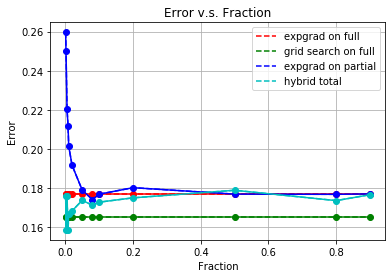

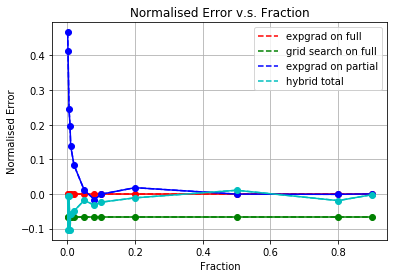

In [15]:
# Print Error and plot them
abs_error = error_expgrad_alls[0]
norm_error_hybrids = []
norm_error_expgrad_fracs = []
norm_error_grid_alls = []
norm_error_expgrad_alls = []

norm_error_exp = (error_expgrad_alls[0] - abs_error)/abs_error
norm_error_grid = (error_grid_alls[0] - abs_error)/abs_error

print('Model\t\t\tFraction\tError\tNormalised Error')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-', error_expgrad_alls[0], norm_error_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-', error_grid_alls[0], norm_error_grid))
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_expgrad_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset',
                                fractions[i], error_expgrad_fracs[i], norm_error))
    
    norm_error_expgrad_fracs.append(norm_error)
    norm_error_expgrad_alls.append(norm_error_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_hybrids[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Hybrid',
                                fractions[i], error_hybrids[i], norm_error))
    
    norm_error_hybrids.append(norm_error)
    norm_error_grid_alls.append(norm_error_grid)

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, error_hybrids,'c--',label="hybrid total")
plt.plot(fractions, error_expgrad_alls,'ro-', fractions, error_grid_alls,'go-',
         fractions, error_expgrad_fracs,'bo-', fractions, error_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_error_hybrids,'c--',label="hybrid total")
plt.plot(fractions, norm_error_expgrad_alls,'ro-', fractions, norm_error_grid_alls,'go-',
         fractions, norm_error_expgrad_fracs,'bo-', fractions, norm_error_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Error')
plt.title('Normalised Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Violation		Normalised Value
Exp.Grad. on full	-		0.0030000000000001137	3.7874795892160286e-14
Grid Search on full	-		0.053235051159029406	16.7450170530098
---------------------------------------------
Exp.Grad. on subset	0.001		0.019859591212544714	5.619863737514905
Exp.Grad. on subset	0.002		0.02859397223216409	8.53132407738803
Exp.Grad. on subset	0.005		0.00048477384532735757	-0.8384087182242141
Exp.Grad. on subset	0.008		0.0019562013592618888	-0.3479328802460371
Exp.Grad. on subset	0.01		0.0003123951795728497	-0.8958682734757167
Exp.Grad. on subset	0.02		0.015020400940283313	4.006800313427771
Exp.Grad. on subset	0.05		0.018403655367517258	5.134551789172419
Exp.Grad. on subset	0.08		0.019995889049383292	5.66529634979443
Exp.Grad. on subset	0.1		0.004374523316044404	0.458174438681468
Exp.Grad. on subset	0.2		0.004660385389611832	0.5534617965372772
Exp.Grad. on subset	0.5		0.0017234415681642579	-0.42551947727858075
Exp.Grad. on subset	0.8		0.0025882616979980566	-0.1372

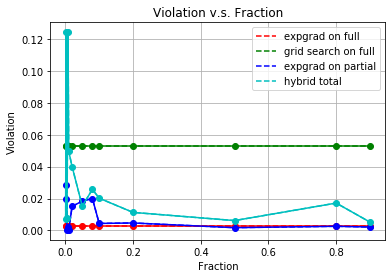

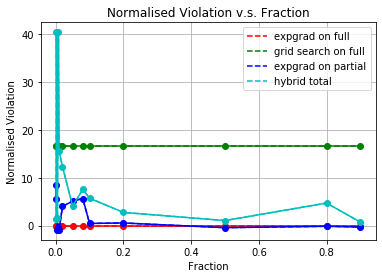

In [16]:
# Print Violation and plot them
norm_vio_hybrids = []
norm_vio_expgrad_fracs = []
norm_vio_grid_alls = []
norm_vio_expgrad_alls = []

norm_vio_exp = (vio_expgrad_alls[0] - eps)/eps
norm_vio_grid = (vio_grid_alls[0] - eps)/eps
print('Model\t\t\tFraction\tViolation\t\tNormalised Value')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-',
                            vio_expgrad_alls[0], norm_vio_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-',
                            vio_grid_alls[0], norm_vio_grid))

print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_expgrad_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset', fractions[i],
                                    vio_expgrad_fracs[i], norm_vio))
    norm_vio_expgrad_fracs.append(norm_vio)
    norm_vio_expgrad_alls.append(norm_vio_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_hybrids[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Hybrid', fractions[i],
                                    vio_hybrids[i], norm_vio))
    norm_vio_hybrids.append(norm_vio)
    norm_vio_grid_alls.append(norm_vio_grid)
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, vio_hybrids,'c--',label="hybrid total")
plt.plot(fractions, vio_expgrad_alls,'ro-', fractions, vio_grid_alls,'go-',
         fractions, vio_expgrad_fracs,'bo-', fractions, vio_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_vio_hybrids,'c--',label="hybrid total")
plt.plot(fractions, norm_vio_expgrad_alls,'ro-', fractions, norm_vio_grid_alls,'go-',
         fractions, norm_vio_expgrad_fracs,'bo-', fractions, norm_vio_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Violation')
plt.title('Normalised Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

## Experiment 2: Hybrid 2

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the `weights` from exp grad on partial dataset.

In [17]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [18]:
error_grid_pmf_fracs = []
vio_grid_pmf_fracs = []

for i in range(len(fractions)):
    predictors = predictors_grid_fracs[i]
    weights_logistic = weights_exp_fracs[i]
    def Qlog(X): return _pmf_predict(X, predictors, weights_logistic)[:,1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    error_grid_search_pmf = error.gamma(Qlog)[0]
    
    vio_grid_pmf_fracs.append(violation_grid_search_pmf)
    error_grid_pmf_fracs.append(error_grid_search_pmf)
    

Model			Fraction	Error	Normalised Error
Exp.Grad. on full	-		0.1770107780079719	0.0
Grid Search on full	-		0.16535118700285617	-0.06586938454442945
---------------------------------------------
Exp.Grad. on subset	0.001		0.2596996206178793	0.46714015689023985
Exp.Grad. on subset	0.002		0.2503181172892152	0.4141405405152324
Exp.Grad. on subset	0.005		0.22046979643931552	0.2455162274321306
Exp.Grad. on subset	0.008		0.21189797874634753	0.19709082763765057
Exp.Grad. on subset	0.01		0.20139012902208916	0.13772805977396077
Exp.Grad. on subset	0.02		0.19164476671515632	0.08267286812628634
Exp.Grad. on subset	0.05		0.1789273469198095	0.010827413637780123
Exp.Grad. on subset	0.08		0.17417206180799147	-0.016036968098364014
Exp.Grad. on subset	0.1		0.17689372162078817	-0.000661295252758349
Exp.Grad. on subset	0.2		0.1802196356827461	0.01812803554046678
Exp.Grad. on subset	0.5		0.17692747776759787	-0.0004705941712220658
Exp.Grad. on subset	0.8		0.1768237887429446	-0.001056372200222084
Exp.Grad. o

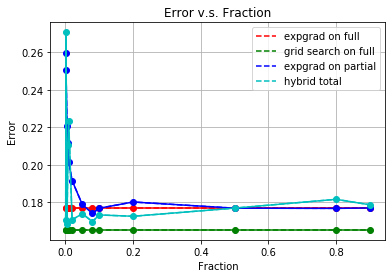

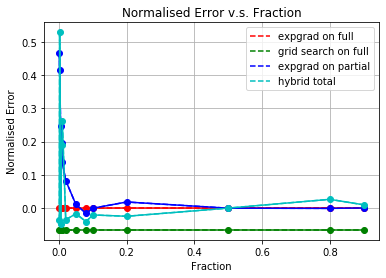

In [19]:
# Print Error and plot them
abs_error = error_expgrad_alls[0]
norm_error_grid_pmf_fracs = []
norm_error_expgrad_fracs = []
norm_error_grid_alls = []
norm_error_expgrad_alls = []

norm_error_exp = (error_expgrad_alls[0] - abs_error)/abs_error
norm_error_grid = (error_grid_alls[0] - abs_error)/abs_error

print('Model\t\t\tFraction\tError\tNormalised Error')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-', error_expgrad_alls[0], norm_error_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-', error_grid_alls[0], norm_error_grid))
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_expgrad_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset',
                                fractions[i], error_expgrad_fracs[i], norm_error))
    
    norm_error_expgrad_fracs.append(norm_error)
    norm_error_expgrad_alls.append(norm_error_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_grid_pmf_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Hybrid',
                                fractions[i], error_grid_pmf_fracs[i], norm_error))
    
    norm_error_grid_pmf_fracs.append(norm_error)
    norm_error_grid_alls.append(norm_error_grid)

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, error_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, error_expgrad_alls,'ro-', fractions, error_grid_alls,'go-',
         fractions, error_expgrad_fracs,'bo-', fractions, error_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_error_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, norm_error_expgrad_alls,'ro-', fractions, norm_error_grid_alls,'go-',
         fractions, norm_error_expgrad_fracs,'bo-', fractions, norm_error_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Error')
plt.title('Normalised Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Violation		Normalised Value
Exp.Grad. on full	-		0.0030000000000001137	3.7874795892160286e-14
Grid Search on full	-		0.053235051159029406	16.7450170530098
---------------------------------------------
Exp.Grad. on subset	0.001		0.019859591212544714	5.619863737514905
Exp.Grad. on subset	0.002		0.02859397223216409	8.53132407738803
Exp.Grad. on subset	0.005		0.00048477384532735757	-0.8384087182242141
Exp.Grad. on subset	0.008		0.0019562013592618888	-0.3479328802460371
Exp.Grad. on subset	0.01		0.0003123951795728497	-0.8958682734757167
Exp.Grad. on subset	0.02		0.015020400940283313	4.006800313427771
Exp.Grad. on subset	0.05		0.018403655367517258	5.134551789172419
Exp.Grad. on subset	0.08		0.019995889049383292	5.66529634979443
Exp.Grad. on subset	0.1		0.004374523316044404	0.458174438681468
Exp.Grad. on subset	0.2		0.004660385389611832	0.5534617965372772
Exp.Grad. on subset	0.5		0.0017234415681642579	-0.42551947727858075
Exp.Grad. on subset	0.8		0.0025882616979980566	-0.1372

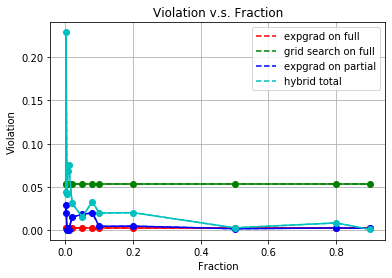

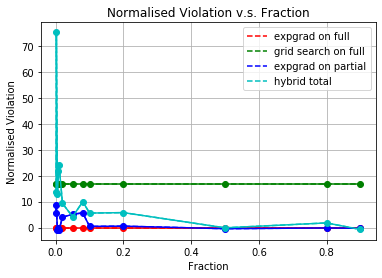

In [20]:
# Print Violation and plot them
norm_vio_grid_pmf_fracs = []
norm_vio_expgrad_fracs = []
norm_vio_grid_alls = []
norm_vio_expgrad_alls = []

norm_vio_exp = (vio_expgrad_alls[0] - eps)/eps
norm_vio_grid = (vio_grid_alls[0] - eps)/eps
print('Model\t\t\tFraction\tViolation\t\tNormalised Value')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-',
                            vio_expgrad_alls[0], norm_vio_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-',
                            vio_grid_alls[0], norm_vio_grid))

print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_expgrad_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset', fractions[i],
                                    vio_expgrad_fracs[i], norm_vio))
    norm_vio_expgrad_fracs.append(norm_vio)
    norm_vio_expgrad_alls.append(norm_vio_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_grid_pmf_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Hybrid', fractions[i],
                                    vio_grid_pmf_fracs[i], norm_vio))
    norm_vio_grid_pmf_fracs.append(norm_vio)
    norm_vio_grid_alls.append(norm_vio_grid)
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, vio_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, vio_expgrad_alls,'ro-', fractions, vio_grid_alls,'go-',
         fractions, vio_expgrad_fracs,'bo-', fractions, vio_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_vio_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, norm_vio_expgrad_alls,'ro-', fractions, norm_vio_grid_alls,'go-',
         fractions, norm_vio_expgrad_fracs,'bo-', fractions, norm_vio_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Violation')
plt.title('Normalised Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Fraction	Normalised Error	Normalised Violation
0.001		-0.03606836027091509	13.75322491558486
0.002		0.5289372788088075	75.2890978206127
0.005		-0.046968031569927175	12.877347197665978
0.008		0.1890188942549361	21.81693260623124
0.01		0.2614657972054799	23.938693059317245
0.02		-0.03550639887968078	9.30704911638038
0.05		-0.017055509885837403	4.2109903710235255
0.08		-0.04094738376832456	9.998571415367309
0.1		-0.02084764772572012	5.595205404319335
0.2		-0.024797604702246175	5.7683390795177845
0.5		-0.0002814500646350289	-0.08716123739677956
0.8		0.026170539612585062	1.7966000549513037
0.9		0.009681816684718401	-0.7233441171289962
----------------------------------------------
0.001		-0.00444994957576821	1.3198601561982835
0.002		-0.10386615363521134	40.41347368352981
0.005		-0.006531964320468594	1.6472470283816125
0.008		-0.10386615363521134	40.41347368352981
0.01		-0.059102836624153166	15.561509394659218
0.02		-0.04886626412937635	12.329453406651115
0.05		-0.018156546645045724	4.09582

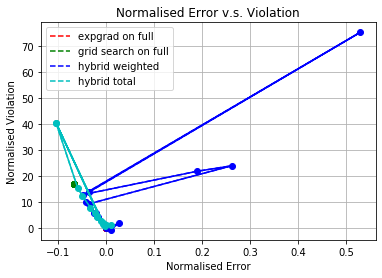

In [25]:
# Violation vs error
print('{}\t{}\t{}'.format('Fraction', 'Normalised Error', 'Normalised Violation'))
for i in range(len(fractions)):
    print('{}\t\t{}\t{}'.format(fractions[i], norm_error_grid_pmf_fracs[i], norm_vio_grid_pmf_fracs[i]))

print('----------------------------------------------')
for i in range(len(fractions)):
    print('{}\t\t{}\t{}'.format(fractions[i], norm_error_hybrids[i], norm_vio_hybrids[i]))

l1 = plt.plot(norm_error_expgrad_alls, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(norm_error_grid_alls, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(norm_error_grid_pmf_fracs, norm_vio_grid_pmf_fracs,'b--',label="hybrid weighted")
l4 = plt.plot(norm_error_hybrids, norm_vio_hybrids,'c--',label="hybrid total")
plt.plot(norm_error_expgrad_alls, norm_vio_expgrad_alls,'ro-', norm_error_grid_alls, norm_vio_grid_alls,'go-',
         norm_error_grid_pmf_fracs, norm_vio_grid_pmf_fracs,'bo-', norm_error_hybrids, norm_vio_hybrids,'co-')
plt.xlabel('Normalised Error')
plt.ylabel('Normalised Violation')
plt.title('Normalised Error v.s. Violation')
plt.grid()
plt.legend()
plt.show()

## Experiment 3: Hybrid 3

### Notes:

1. For grid search in hybrid model, we get `y_pred` by evaluating LP over the grid predictors to re-assign `weights` to each predictor.

In [26]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [ ]:
error_grid_pmf_fracs_reweighted = []
vio_grid_pmf_fracs_reweighted = []

for i in range(len(fractions)):
    predictors = predictors_grid_fracs[i]
    
    
    
    def Qlog(X): return _pmf_predict(X, predictors, weights_logistic)[:,1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    error_grid_search_pmf = error.gamma(Qlog)[0]
    
    vio_grid_pmf_fracs_reweighted.append(violation_grid_search_pmf)
    error_grid_pmf_fracs_reweighted.append(error_grid_search_pmf)
    